<a href="https://colab.research.google.com/github/Manvithtech07/Forest-Fire-Detection-And-Prediction/blob/main/notebooks/modeling_and_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
GDRIVE_PROJECT_PATH = "/content/drive/My Drive/"
DATA_PATH = f"{GDRIVE_PROJECT_PATH}/data"

csv_path = f"{DATA_PATH}/training_data.csv"

df = pd.read_csv(csv_path)
print(f"Shape of the data: {df.shape}")
print("\nFirst 5 rows:")
display(df.head())

print("\nData Info (checking for nulls):")
df.info()

Shape of the data: (10000, 9)

First 5 rows:


,ndvi_pre,ndvi_post,nbr_pre,nbr_post,elevation,slope,aspect,dNBR,Burned
0,0.177976,0.096213,0.107546,-0.024990,1196.689297,89.99911,345.58290,0.132537,1
1,0.234447,0.154161,0.190272,0.073477,-32767.000000,-9999.00000,-9999.00000,0.116795,1
2,0.312417,0.142838,0.247186,0.040099,1533.746324,89.99904,55.28233,0.207087,1
3,0.231127,0.162649,0.182231,0.075043,851.715557,89.99912,223.24180,0.107188,1
4,0.378242,0.148193,0.325877,0.054974,1808.838535,89.99906,301.75793,0.270903,1



Data Info (checking for nulls):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   ndvi_pre   10000 non-null  float64
 1   ndvi_post  10000 non-null  float64
 2   nbr_pre    10000 non-null  float64
 3   nbr_post   10000 non-null  float64
 4   elevation  10000 non-null  float64
 5   slope      10000 non-null  float64
 6   aspect     10000 non-null  float64
 7   dNBR       10000 non-null  float64
 8   Burned     10000 non-null  int64  
dtypes: float64(8), int64(1)
memory usage: 703.3 KB


## 1. Define Features (X) and Target (y)

We must separate our data:
* **`y` (Target):** The `Burned` column. This is what we want to predict.
* **`X` (Features):** All the other columns that our model will use as *clues*.

**CRITICAL:** We **drop** the `dNBR` column from our features. Because our `Burned` column was created *directly from* `dNBR`. Using `dNBR` to predict `Burned` would be "cheating" or **data leakage**. We want the model to learn from the *environmental* features, not the answer key.

In [4]:
y = df['Burned']

X = df.drop(columns=['Burned', 'dNBR'])
print("Target (y) shape:", y.shape)
print("Features (X) shape:", X.shape)
print("\nFeatures (X) columns:")
display(X.head())

Target (y) shape: (10000,)
Features (X) shape: (10000, 7)

Features (X) columns:


,ndvi_pre,ndvi_post,nbr_pre,nbr_post,elevation,slope,aspect
0,0.177976,0.096213,0.107546,-0.024990,1196.689297,89.99911,345.58290
1,0.234447,0.154161,0.190272,0.073477,-32767.000000,-9999.00000,-9999.00000
2,0.312417,0.142838,0.247186,0.040099,1533.746324,89.99904,55.28233
3,0.231127,0.162649,0.182231,0.075043,851.715557,89.99912,223.24180
4,0.378242,0.148193,0.325877,0.054974,1808.838535,89.99906,301.75793


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # 'stratify=y' is crucial for a balanced dataset!
)

print(f"Training set size: {X_train.shape[0]} samples")
print(f"Testing set size: {X_test.shape[0]} samples")

Training set size: 8000 samples
Testing set size: 2000 samples


In [8]:
from sklearn.ensemble import RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestClassifier(n_jobs=-1, random_state=42)

In [9]:
y_pred = rf_model.predict(X_test)
y_pred

array([0, 1, 0, ..., 1, 1, 1])

In [10]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy * 100:.2f}%")

print("\n--- Classification Report ---")
print(classification_report(y_test, y_pred, target_names=['Unburned (0)', 'Burned (1)']))

print("\n--- Confusion Matrix ---")
cm = confusion_matrix(y_test, y_pred)
print(cm)

Model Accuracy: 98.45%

--- Classification Report ---
              precision    recall  f1-score   support

Unburned (0)       0.99      0.98      0.98      1000
  Burned (1)       0.98      0.99      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000


--- Confusion Matrix ---
[[979  21]
 [ 10 990]]


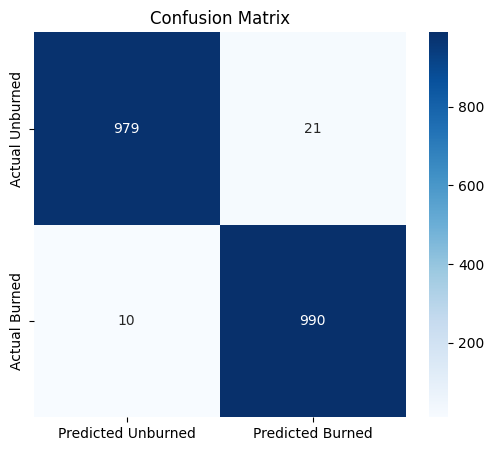

In [11]:
import seaborn as sns
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Predicted Unburned', 'Predicted Burned'],
            yticklabels=['Actual Unburned', 'Actual Burned'])
plt.title('Confusion Matrix')
plt.show()

     Feature  Importance
3   nbr_post    0.296581
0   ndvi_pre    0.249060
2    nbr_pre    0.224704
1  ndvi_post    0.178642
4  elevation    0.022946
5      slope    0.015287
6     aspect    0.012779


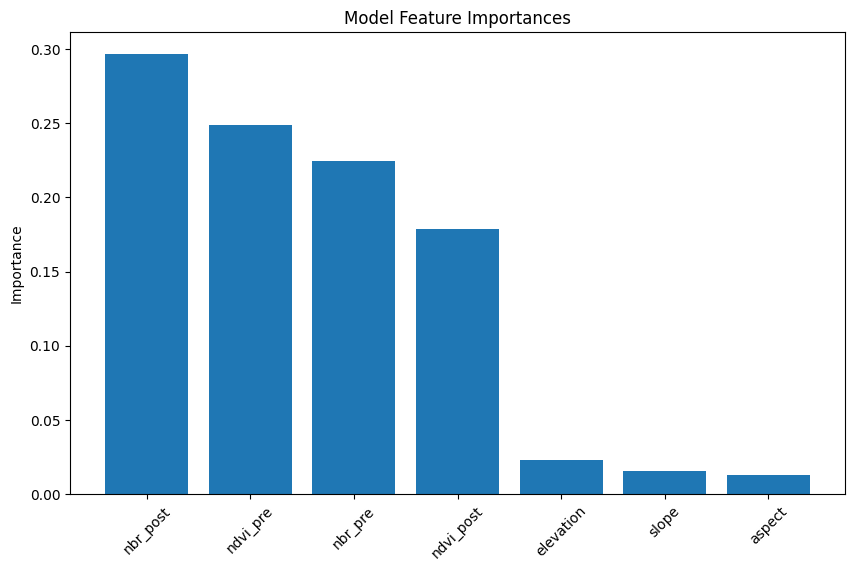

In [12]:
importances = rf_model.feature_importances_
feature_names = X.columns

feature_importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feature_importance_df)
plt.figure(figsize=(10, 6))
plt.bar(feature_importance_df['Feature'], feature_importance_df['Importance'])
plt.title('Model Feature Importances')
plt.ylabel('Importance')
plt.xticks(rotation=45)
plt.show()

In [13]:
import joblib
model_path = f"{GDRIVE_PROJECT_PATH}/data/random_forest_model.joblib"
joblib.dump(rf_model, model_path)
print(f"Model saved to: {model_path}")

Model saved to: /content/drive/My Drive//data/random_forest_model.joblib


## 2. Generate Final Prediction Map

This is the final step. We will:
1.  Load all 7 of our feature rasters (excluding `dNBR`).
2.  Stack them into a single, massive 3D array (`[rows, cols, features]`).
3.  Reshape this array into a 2D list of pixels (`[total_pixels, features]`) that our model can read.
4.  Feed this entire list to our trained `rf_model` to get a prediction for every pixel.
5.  Reshape the predictions back into a 2D map.
6.  Save this final map as a new GeoTIFF file.

In [14]:
!pip install rasterio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 81.0 MB/s eta 0:00:00


In [18]:
!pip install -q scikit-image
from skimage.transform import resize
FEATURES_PATH = f"{DATA_PATH}/features"
feature_files = [
    "ndvi_pre.tif",
    "ndvi_post.tif",
    "nbr_pre.tif",
    "nbr_post.tif",
    "elevation.tif",
    "slope.tif",
    "aspect.tif"
]

raster_data = []
template_meta = None
master_shape = None

try:
    template_path = f"{FEATURES_PATH}/{feature_files[0]}"
    with rasterio.open(template_path) as src:
        master_shape = src.read(1).shape
        template_meta = src.meta.copy()
    print(f"Master shape (from {feature_files[0]}) is: {master_shape}")
    for filename in feature_files:
        file_path = f"{FEATURES_PATH}/{filename}"
        with rasterio.open(file_path) as src:
            data_array = src.read(1)

            if data_array.shape != master_shape:
                print(f"  -> Resizing '{filename}' from {data_array.shape} to {master_shape}...")
                data_array = resize(
                    data_array,
                    master_shape,
                    order=1, # 'bilinear' interpolation
                    preserve_range=True,
                    anti_aliasing=True
                )
            else:
                print(f"  -> Shape for '{filename}' is correct.")

        raster_data.append(data_array)

    data_cube = np.stack(raster_data)
    print(f"\nData cube shape: {data_cube.shape}")

except Exception as e:
    print(f"FATAL ERROR: Could not load or resize files. {e}")

Master shape (from ndvi_pre.tif) is: (2337, 3669)
  -> Shape for 'ndvi_pre.tif' is correct.
  -> Shape for 'ndvi_post.tif' is correct.
  -> Shape for 'nbr_pre.tif' is correct.
  -> Shape for 'nbr_post.tif' is correct.
  -> Resizing 'elevation.tif' from (2215, 3486) to (2337, 3669)...
  -> Resizing 'slope.tif' from (2215, 3486) to (2337, 3669)...
  -> Resizing 'aspect.tif' from (2215, 3486) to (2337, 3669)...

Data cube shape: (7, 2337, 3669)


In [19]:
n_features, n_rows, n_cols = data_cube.shape

data_flat = data_cube.transpose(1, 2, 0).reshape(-1, n_features)

print(f"Data reshaped to: {data_flat.shape}")

nodata_mask = np.isnan(data_flat).any(axis=1)

data_filled = np.nan_to_num(data_flat, nan=0)

full_predictions = rf_model.predict(data_filled)

prediction_map = full_predictions.reshape(n_rows, n_cols)


prediction_map = prediction_map.astype('float32') # Convert to float
prediction_map[nodata_mask.reshape(n_rows, n_cols)] = -99.0

Data reshaped to: (8574453, 7)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


FINAL MAP SAVED TO: /content/drive/My Drive//data/features/FINAL_PREDICTION_MAP.tif


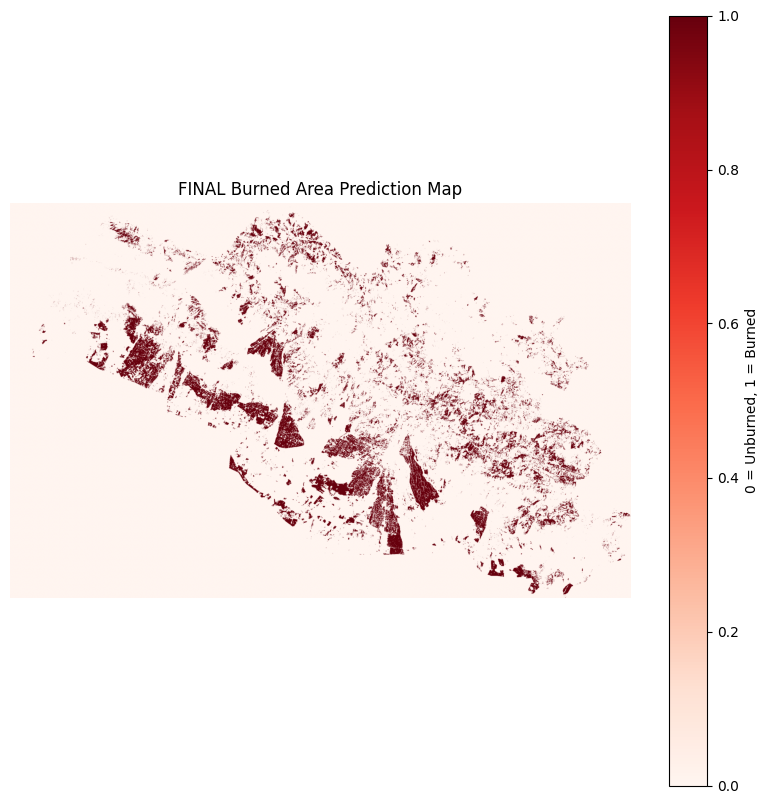

In [20]:
map_output_path = f"{FEATURES_PATH}/FINAL_PREDICTION_MAP.tif"

template_meta.update({
    'dtype': 'float32',
    'count': 1,
    'nodata': -99.0
})

with rasterio.open(map_output_path, 'w', **template_meta) as dst:
    dst.write(prediction_map, 1)

print(f"FINAL MAP SAVED TO: {map_output_path}")

# Plot the Final Map ---
plt.figure(figsize=(10, 10))
# We use a simple 'Reds' colormap (0=White, 1=Red)
plt.imshow(prediction_map, cmap='Reds', vmin=0, vmax=1)
plt.title("FINAL Burned Area Prediction Map")
plt.colorbar(label="0 = Unburned, 1 = Burned")
plt.axis('off')
plt.show()